In [5]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools

import scipy.linalg as sc

import warnings as w
from IPython.display import Image

from utils import qualityMACAPE, qualityRMSE, InitExponentialSmoothing, AdaptiveExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [6]:
from sklearn.utils.extmath import softmax

In [7]:
softmax([[1.,3,3],[3.,1.,0] ])

array([[0.06337894, 0.46831053, 0.46831053],
       [0.84379473, 0.1141952 , 0.04201007]])

In [8]:
# k = 2
# x = [1,2,3,4]
# h = 1
# forecast_ba = np.array( [[-1, -2, -3, -4, -5], [-2, -4, -6, -8, -10]] )
# sc.hankel( x[:-(k-1)], [-1]+list(x[-(k-1):]) )[:-h, :], forecast_ba[:, k-1+h:-h]

In [9]:
def arbitrating_composition(ts, h, params):
    '''
    Parameters
    ts <K \times array> - batch of time series shape=(batch_size, K)
    h <integer scalar> - forecasting delay
    params <dict> - dictionary with 

        base_algs - array of <dict> with params
            base_alg <string> - name of base algorithm
            BaseAlfParams <dict> dictionary of base algorithm's params
    '''
    #    forecast = np.empty(( len(base_algs), len(x) + h ))
    X_train, Y_train = [], []
    forecast = []
    for x_i, x in enumerate(ts):
        # base algs Forecasts
        base_algs = params['base_alg_params']

        forecast_ba = np.empty(( len(base_algs), len(x) + h ))
        forecast_ba[:] = np.nan
    
        #     forecast TS by each base algs
        #     be careful with eval() function    
        for n, base_alg in enumerate(base_algs):
            forecast_ba[n] = eval(base_alg['base_alg'])(x, h, base_alg['base_algs_params'])
        
        rf = []  # random forest
        step = 10  # TODO: make it parameter
        k = 10  # size of sample for meta-learner TODO: make it parameter
        
        forecast_i = []
        xx = sc.hankel( x[:-(k-1)], [-1]+list(x[-(k-1):]) )[:-h, :]
        yy = abs(forecast_ba[:, k-1+h:-h] - np.vstack([ x[k-1+h:], x[k-1+h:] ]))
        
        #     обучение мета-лёрнера (каждые <step> отсчётов времени re-train мета-лёрнера)
        #     1) собрать обучающую выборку
        #     2) fit RF
        
        for t in range( xx.shape[0] // step - 1 ):
            ind = [ i for i in range(len(yy)) if not np.isnan(yy[i]).any() ]
            batch = [ xx[t*step: (t+1)*step ][ind], yy[t*step: (t+1)*step ][ind] ]
            X_train, Y_train = X_train + [batch[0]], Y_train + [batch[1]]

            for i in range(len(rf)):
                rf[i].fit(X_train, Y_train)

            # (недо) прогноз ошибки каким-то методом по каждому базовому алгоритму
            # прогноз мета-лернера по каждому базовому алгоритму
            error = [ -rf[i].predict(xx, yy[i]) for i in range(len(rf)) ]
            for tt in range(t*step, (t+1)*step):
                if np.isnan(yy[tt]):
                    forecast_i.append(np.nan)
                else:
                    forecast_i.append(softmax(error) * forecast_ba[tt])
            forecast.append(forecast_i)
        return forecast

# Define base algorithms

In [45]:
base_algs = [{'base_alg':'InitExponentialSmoothing', 'base_algs_params':{'alpha':0.1, 'AdaptationPeriod':10}},
            {'base_alg':'AdaptiveExponentialSmoothing', 'base_algs_params':{'alpha':0.2,'gamma':0.01, 'AdaptationPeriod':10}}
#                  {'base_alg':'AdaptiveSimpleExponentialSmoothing', 'base_algs_params':{'alpha':0.1, 'gamma':0.01}},
#                 {'base_alg':'TheilWageSmoothing', 'base_algs_params':{'alpha':0.3, 'beta':0.9,'delta':0.9}}
]

In [46]:
for ba in range(len(base_algs)):
    print(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_alg_params'])")

InitExponentialSmoothing(x,h,base_algs[0]['base_alg_params'])
AdaptiveExponentialSmoothing(x,h,base_algs[1]['base_alg_params'])


In [47]:
# Read data (time series)
#ts = pd.read_csv('https://raw.githubusercontent.com/ml-mipt/ml-mipt-part2/master/2017/seminars/1_ts_esm/data/TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts = pd.read_csv('./data/TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts.index.names = ['Timestamp']
ts = ts.sort_index() # sort index

In [48]:
# Define forecast perameters
h = 1 # horizon forecast

# structure of forecasts
frc_ts = pd.DataFrame(index = ts.index.append(pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h))), columns = ts.columns)
FRC_TS = dict()

In [49]:
gamma = 0.01
eps = 1.0
params = {'gamma': gamma, 'eps': eps, 'base_alg_params': base_algs}
arbitrating_composition([ ts[cntr] for cntr in ts.columns], h, params)

(1502, 10) (2, 1502)


In [43]:
X_train, X_val, X_test = [], [], []
Y_train, Y_val, Y_test = [], [], []

for cntr in ts.columns:
    ser = ts[cntr]
    tr, v, tst = ser[:1000], ser[1000:1200], ser[1200:]
    X_train.append(tr)
    X_val.append(v)
    X_test.append(tst)
    
    FORECAST_BA = np.empty(( len(base_algs), len(ser) + h ))
    FORECAST_BA[:] = np.nan
    
    for n, base_alg in enumerate(base_algs):
        FORECAST_BA[n] = eval(base_alg['base_alg'])(ser, h, base_alg['base_algs_params'])
        
    Y_train.append(FORECAST_BA[:, :1000])
    Y_val.append(FORECAST_BA[:, 1000:1200])
    Y_test.append(FORECAST_BA[:, 1200:])

In [44]:
Y_test[0].shape

(2, 313)

In [15]:
X_test[0].shape

(312,)

In [9]:
k = 3
x = np.arange(7)
sc.hankel(x[:-(k-1)], [-1]+list(x[-(k-1):]) )

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6]])

In [10]:
k = 10
for x, y in [(X_train, Y_train), (X_val, Y_val), (X_test, Y_test)]:
    for i in range(len(x)):
        x[i] = sc.hankel(x[i][:-(k-1)], [-1]+list(x[i][-(k-1):]) )[:-h, :]
        y[i] = y[i][0, k-1+h:]  # [:, k-1+h:-h]
        print(x[i].shape, y[i].shape)
X_train, X_val, X_test = np.vstack(X_train), np.vstack(X_val), np.vstack(X_test)
Y_train, Y_val, Y_test = np.vstack(Y_train).flatten(), np.vstack(Y_val).flatten(), np.vstack(Y_test).flatten()

(990, 10) (990,)
(990, 10) (990,)
(990, 10) (990,)
(990, 10) (990,)
(990, 10) (990,)
(990, 10) (990,)
(990, 10) (990,)
(990, 10) (990,)
(990, 10) (990,)
(990, 10) (990,)
(990, 10) (990,)
(190, 10) (190,)
(190, 10) (190,)
(190, 10) (190,)
(190, 10) (190,)
(190, 10) (190,)
(190, 10) (190,)
(190, 10) (190,)
(190, 10) (190,)
(190, 10) (190,)
(190, 10) (190,)
(190, 10) (190,)
(302, 10) (303,)
(302, 10) (303,)
(302, 10) (303,)
(302, 10) (303,)
(302, 10) (303,)
(302, 10) (303,)
(302, 10) (303,)
(302, 10) (303,)
(302, 10) (303,)
(302, 10) (303,)
(302, 10) (303,)


In [11]:
X_train.shape, X_val.shape, X_test.shape

((10890, 10), (2090, 10), (3322, 10))

In [12]:
Y_train.shape, Y_val.shape, Y_test.shape

((10890,), (2090,), (3333,))

In [17]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor

In [74]:
lr = LinearRegression()

In [75]:
lr.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [ ]:
lr.

In [98]:
# run Adaptive Selection
gamma = 0.01
eps = 1.0
for cntr in ts.columns:
    print(ts[cntr].shape)
    frc_ts[cntr] = adaptive_selection(ts[cntr],h, {'gamma':gamma, 'eps': eps, 'base_alg_params':base_algs})
FRC_TS['AS gamma %.2f eps %.2f' % (gamma, eps)] = frc_ts

(1512,)
(1512,)
(1512,)
(1512,)
(1512,)
(1512,)
(1512,)
(1512,)
(1512,)
(1512,)
(1512,)


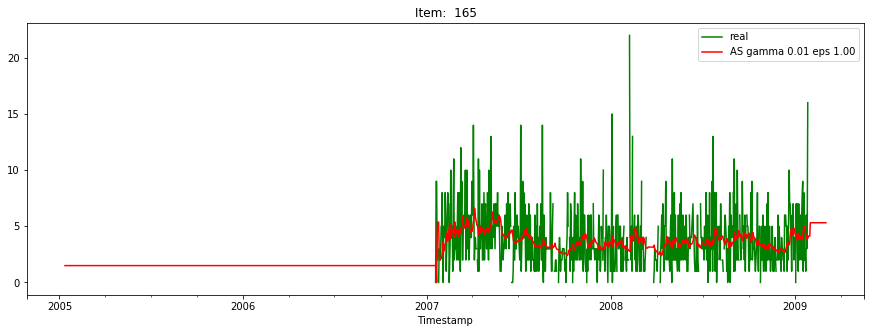

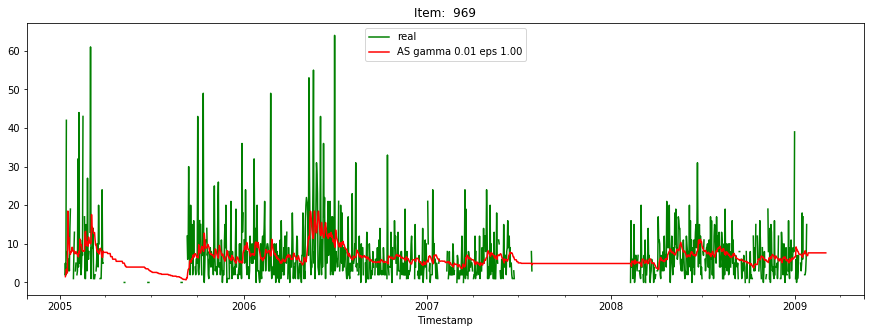

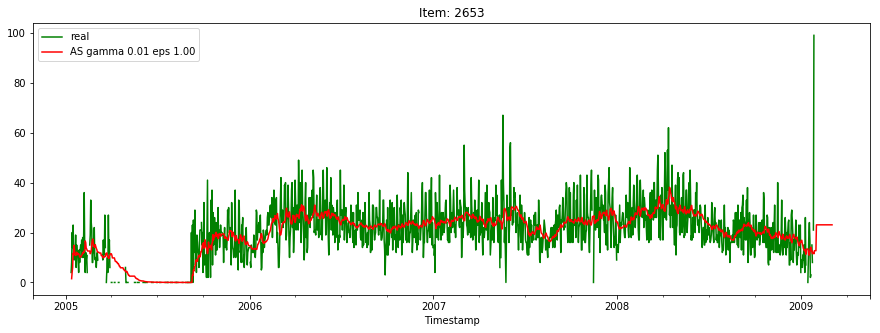

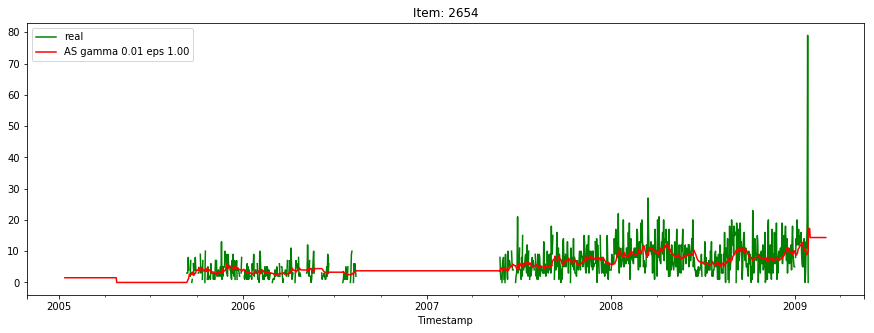

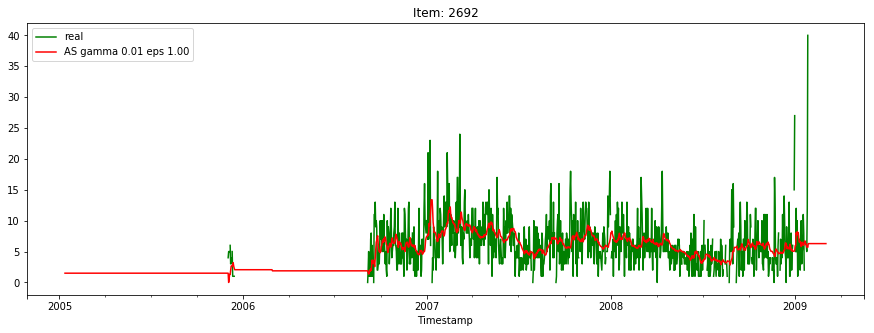

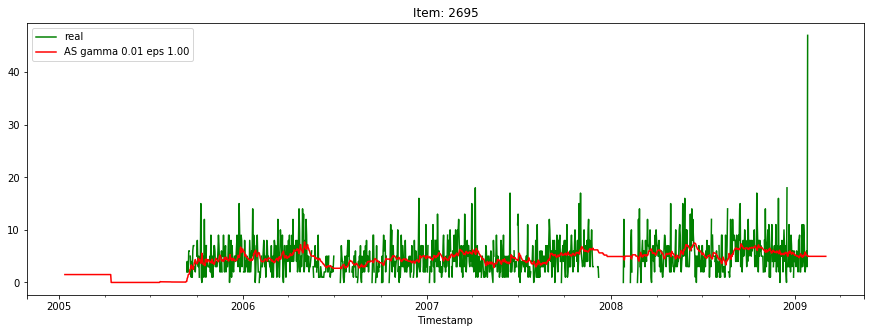

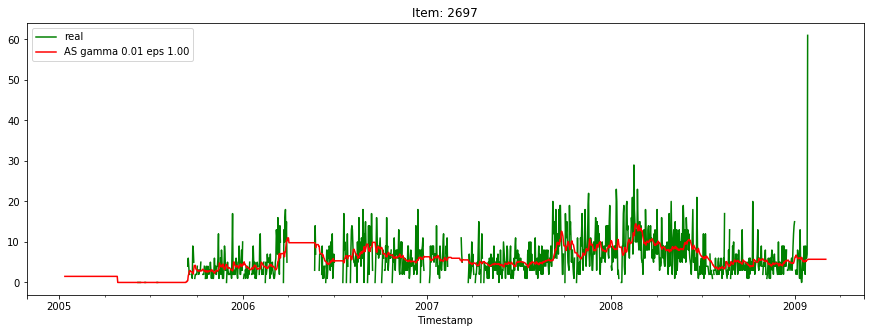

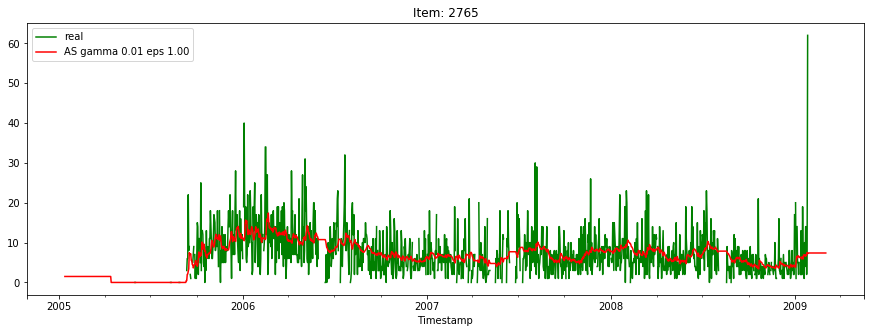

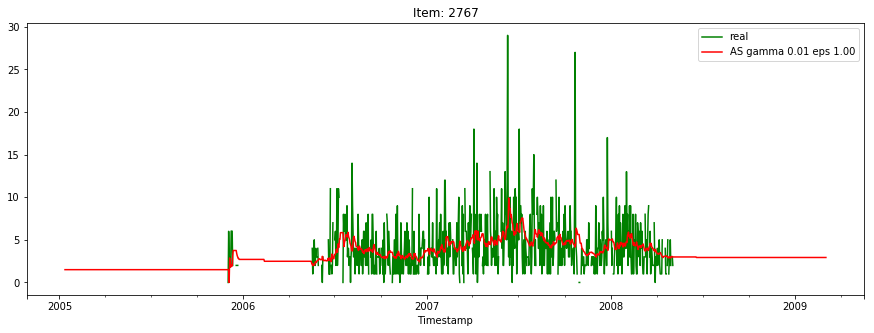

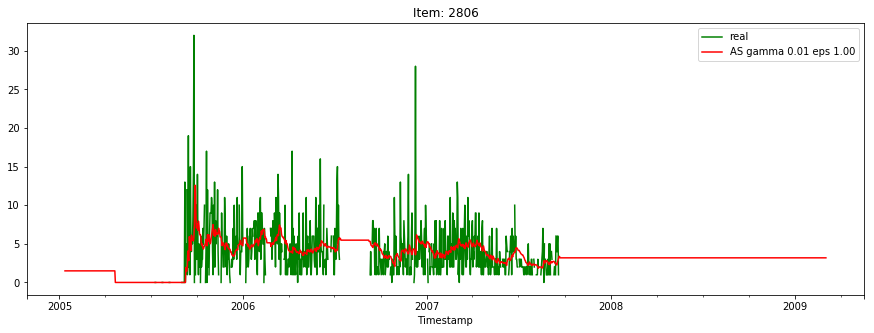

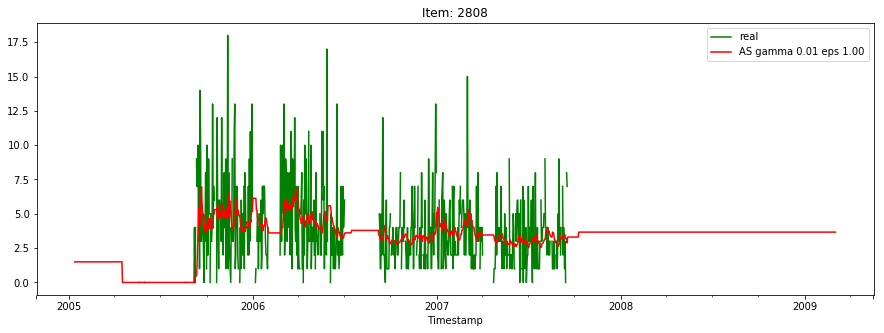

In [99]:
# draw forecast of Adaprive Selection
alg_name = 'AS gamma 0.01 eps 1.00'
for col in ts.columns:
    ts[col].plot(figsize=(15,5), color='green', label='real')
    forecast = FRC_TS[alg_name]
    forecast[col].plot(color='red', label=alg_name)
    plt.title(col)
    plt.legend()
    plt.show()

In [ ]:
алгоритм - это уже подобранные параметры модели (отличие модели от алгоритма)
модель - рандом форест, алгоритм - сам лес

один алгоритм - на все временные ряды, 1000 - трейн, 200 валидация, 300 тест